# Minibatch Stochastic Gradient Descent

Trong học sâu, việc tối ưu hóa các tham số của mô hình là một bước quan trọng để đạt được hiệu suất tốt nhất. Có nhiều phương pháp tối ưu hóa khác nhau, trong đó Gradient Descent (GD) và Stochastic Gradient Descent (SGD) là hai phương pháp phổ biến. Tuy nhiên, cả hai đều có những hạn chế riêng. Minibatch Stochastic Gradient Descent (Minibatch SGD) được xem là một giải pháp cân bằng giữa hai phương pháp này, mang lại hiệu quả cả về mặt tính toán và thống kê.

## Vectorization and Caches

Trọng tâm của quyết định sử dụng minibatches là hiệu quả tính toán. Điều này dễ hiểu nhất khi xem xét song song với nhiều GPU và nhiều máy chủ. Trong trường hợp này, chúng ta cần gửi ít nhất một hình ảnh cho mỗi GPU. Với 8 GPU trên mỗi máy chủ và 16 máy chủ, chúng tôi đã có kích thước minibatch là 128. 

Mọi thứ tinh tế hơn một chút khi nói đến GPU đơn lẻ hoặc thậm chí CPU. Các thiết bị này có nhiều loại bộ nhớ, thường là nhiều loại đơn vị tính toán và hạn chế băng thông khác nhau giữa chúng. Ví dụ, CPU có một số lượng nhỏ các thanh ghi và sau đó là L1, L2 và trong một số trường hợp thậm chí bộ nhớ cache L3 (được chia sẻ giữa các lõi bộ xử lý khác nhau). Các bộ nhớ đệm này có kích thước và độ trễ ngày càng tăng (đồng thời chúng giảm băng thông). Nó đủ để nói, bộ xử lý có khả năng thực hiện nhiều hoạt động hơn so với những gì giao diện bộ nhớ chính có thể cung cấp. 

* CPU 2GHz với 16 lõi và vectorization AVX-512 có thể xử lý lên đến $2 \cdot 10^9 \cdot 16 \cdot 32 = 10^{12}$ byte mỗi giây. Khả năng của GPU dễ dàng vượt quá con số này theo hệ số 100. Mặt khác, một bộ xử lý máy chủ tầm trung có thể không có nhiều hơn 100 Gb/s băng thông, tức là, ít hơn một phần mười những gì sẽ được yêu cầu để giữ cho bộ xử lý ăn. Để làm cho vấn đề tồi tệ hơn, không phải tất cả truy cập bộ nhớ được tạo ra bằng nhau: đầu tiên, giao diện bộ nhớ thường rộng 64 bit hoặc rộng hơn (ví dụ, trên GPU lên đến 384 bit), do đó đọc một byte duy nhất phải chịu chi phí truy cập rộng hơn nhiều.
* Có chi phí đáng kể cho truy cập đầu tiên trong khi truy cập tuần tự là tương đối rẻ (điều này thường được gọi là một lần đọc liên tục). Có rất nhiều điều cần lưu ý, chẳng hạn như bộ nhớ đệm khi chúng ta có nhiều ổ cắm, chiplet và các cấu trúc khác. Một cuộc thảo luận chi tiết về điều này nằm ngoài phạm vi của phần này. Xem ví dụ, [Wikipedia article](https://en.wikipedia.org/wiki/Cache_hierarchy) này để có một cuộc thảo luận chuyên sâu hơn.

Cách để giảm bớt những hạn chế này là sử dụng một hệ thống phân cấp của bộ nhớ cache CPU thực sự đủ nhanh để cung cấp cho bộ xử lý dữ liệu. Đây là * động lực là* đằng sau việc phân mẻ trong học sâu. Để giữ cho vấn đề đơn giản, hãy xem xét phép nhân ma trận ma trận, nói $\mathbf{A} = \mathbf{B}\mathbf{C}$. Chúng tôi có một số tùy chọn để tính toán $\mathbf{A}$. Ví dụ, chúng tôi có thể thử như sau: 

1. Chúng tôi có thể tính toán $\mathbf{A}_{ij} = \mathbf{B}_{i,:} \mathbf{C}_{:,j}^\top$, tức là, chúng tôi có thể tính toán nó elementwise bằng phương tiện của các sản phẩm chấm.
1. Chúng ta có thể tính toán $\mathbf{A}_{:,j} = \mathbf{B} \mathbf{C}_{:,j}^\top$, tức là, chúng ta có thể tính toán nó một cột tại một thời điểm. Tương tự như vậy chúng ta có thể tính $\mathbf{A}$ một hàng $\mathbf{A}_{i,:}$ tại một thời điểm.
1. We could simply đơn giản compute tính toán $\mathbf{A} = \mathbf{B} \mathbf{C}$.
1. Chúng ta có thể phá vỡ $\mathbf{B}$ và $\mathbf{C}$ thành các ma trận khối nhỏ hơn và tính toán $\mathbf{A}$ một khối tại một thời điểm.

Nếu chúng ta làm theo tùy chọn đầu tiên, chúng ta sẽ cần sao chép một hàng và một vectơ cột vào CPU mỗi khi chúng ta muốn tính một phần tử $\mathbf{A}_{ij}$. Thậm chí tệ hơn, do thực tế là các yếu tố ma trận được căn chỉnh tuần tự, do đó, chúng ta được yêu cầu truy cập nhiều vị trí tách rời cho một trong hai vectơ khi chúng ta đọc chúng từ bộ nhớ. Tùy chọn thứ hai thuận lợi hơn nhiều. Trong đó, chúng ta có thể giữ vector cột $\mathbf{C}_{:,j}$ trong bộ nhớ cache CPU trong khi chúng tôi tiếp tục đi qua $B$. Điều này giảm một nửa yêu cầu băng thông bộ nhớ với truy cập nhanh hơn tương ứng. Tất nhiên, tùy chọn 3 là mong muốn nhất. Thật không may, hầu hết các ma trận có thể không hoàn toàn phù hợp với bộ nhớ cache (đây là những gì chúng ta đang thảo luận sau khi tất cả). Tuy nhiên, tùy chọn 4 cung cấp một giải pháp thay thế thực tế hữu ích: chúng ta có thể di chuyển các khối ma trận vào bộ nhớ cache và nhân chúng cục bộ. Tối ưu hóa thư viện chăm sóc này cho chúng tôi. Chúng ta hãy xem các hoạt động này hiệu quả như thế nào trong thực tế. 

Ngoài hiệu quả tính toán, chi phí được giới thiệu bởi Python và bởi chính khuôn khổ học tập sâu là đáng kể. Nhớ lại rằng mỗi lần chúng ta thực hiện một lệnh, trình thông dịch Python sẽ gửi một lệnh đến công cụ MXNet cần chèn nó vào biểu đồ tính toán và xử lý nó trong quá trình lên lịch. Chi phí như vậy có thể khá bất lợi. Nói tóm lại, rất nên sử dụng vector hóa (và ma trận) bất cứ khi nào có thể.

In [8]:
import time
import numpy as np
import torch
from torch import nn
import d2l

A = torch.zeros(512, 512)
B = torch.randn(512, 512)
C = torch.randn(512, 512)

Vì chúng ta sẽ thường xuyên đo thời gian chạy trong phần còn lại của báo cáo, hãy định nghĩa một bộ đếm thời gian.

In [9]:
class Timer:
    """Record multiple running times."""
    def __init__(self):
        self.times = []
        self.start()

    def start(self):
        """Start the timer."""
        self.tik = time.time()

    def stop(self):
        """Stop the timer and record the time in a list."""
        self.times.append(time.time() - self.tik)
        return self.times[-1]

    def avg(self):
        """Return the average time."""
        return sum(self.times) / len(self.times)

    def sum(self):
        """Return the sum of time."""
        return sum(self.times)

    def cumsum(self):
        """Return the accumulated time."""
        return np.array(self.times).cumsum().tolist()

timer = Timer()

Gán từng phần tử đơn giản là lặp qua tất cả các hàng và cột của $\mathbf{B}$ và $\mathbf{C}$ tương ứng để gán giá trị cho $\mathbf{A}$.

In [10]:
# Compute A = BC one element at a time
timer.start()
for i in range(512):
    for j in range(512):
        A[i, j] = torch.dot(B[i, :], C[:, j])
timer.stop()

10.192130327224731

Một chiến lược nhanh hơn là thực hiện gán theo cột.

In [12]:
# Compute A = BC one column at a time
timer.start()
for j in range(512):
    A[:, j] = torch.mv(B, C[:, j])
timer.stop()

0.04539179801940918

Cuối cùng, phương pháp hiệu quả nhất là thực hiện toàn bộ phép toán trong một khối duy nhất.
Lưu ý rằng việc nhân hai ma trận $\mathbf{B} \in \mathbb{R}^{m \times n}$ và $\mathbf{C} \in \mathbb{R}^{n \times p}$ cần khoảng $2mnp$ phép toán dấu phẩy động,
khi phép nhân và cộng vô hướng được tính là hai phép toán riêng biệt (mặc dù trên thực tế thường được gộp lại).
Do đó, việc nhân hai ma trận kích thước $512 \times 512$ cần khoảng $0.27$ tỷ phép toán dấu phẩy động.
Bây giờ, hãy cùng xem tốc độ tương ứng của các phép toán này.

In [15]:
# Compute A = BC in one go
timer.start()
A = torch.mm(B, C)
timer.stop()

gigaflops = [0.27 / i for i in timer.times]
print(f'performance in Gigaflops: element {gigaflops[0]:.3f}, '
      f'column {gigaflops[1]:.3f}, full {gigaflops[2]:.3f}')

performance in Gigaflops: element 0.026, column 6.013, full 5.948


## Minibatches

Trong quá khứ, chúng tôi đã cho rằng chúng tôi sẽ đọc * minibatches* của dữ liệu chứ không phải là quan sát duy nhất để cập nhật các tham số. Bây giờ chúng tôi đưa ra một lời biện minh ngắn gọn cho nó. Xử lý các quan sát đơn yêu cầu chúng ta thực hiện nhiều phép nhân ma thuật-vector (hoặc thậm chí là vector-vector) đơn lẻ, khá tốn kém và phát sinh một chi phí đáng kể thay mặt cho khuôn khổ học sâu cơ bản. Điều này áp dụng cả để đánh giá một mạng khi áp dụng cho dữ liệu (thường được gọi là suy luận) và khi tính toán gradient để cập nhật các tham số. Đó là, điều này áp dụng bất cứ khi nào chúng tôi thực hiện $\mathbf{w} \leftarrow \mathbf{w} - \eta_t \mathbf{g}_t$ ở đâu 

$$\mathbf{g}_t = \partial_{\mathbf{w}} f(\mathbf{x}_{t}, \mathbf{w})$$

Chúng ta có thể tăng hiệu quả * tính tị* của thao tác này bằng cách áp dụng nó vào một loạt các quan sát tại một thời điểm. Đó là, chúng tôi thay thế gradient $\mathbf{g}_t$ trong một quan sát duy nhất bằng một trong một lô nhỏ 

$$\mathbf{g}_t = \partial_{\mathbf{w}} \frac{1}{|\mathcal{B}_t|} \sum_{i \in \mathcal{B}_t} f(\mathbf{x}_{i}, \mathbf{w})$$

Chúng ta hãy xem điều này làm gì với các thuộc tính thống kê của $\mathbf{g}_t$: vì cả $\mathbf{x}_t$ và tất cả các yếu tố của minibatch $\mathcal{B}_t$ được vẽ đồng đều ngẫu nhiên từ bộ đào tạo, kỳ vọng của gradient vẫn không thay đổi. Mặt khác, phương sai được giảm đáng kể. Kể từ khi gradient minibatch bao gồm $b := |\mathcal{B}_t|$ gradient độc lập đang được trung bình, độ lệch chuẩn của nó được giảm bởi một hệ số $b^{-\frac{1}{2}}$. Bản thân nó, điều này là một điều tốt, vì nó có nghĩa là các bản cập nhật được liên kết đáng tin cậy hơn với gradient đầy đủ. 

Ngây thơ điều này sẽ chỉ ra rằng việc lựa chọn một minibatch lớn $\mathcal{B}_t$ sẽ là mong muốn phổ biến. Than ôi, sau một số điểm, việc giảm thêm độ lệch chuẩn là tối thiểu khi so sánh với sự gia tăng tuyến tính trong chi phí tính toán. Trong thực tế, chúng tôi chọn một minibatch đủ lớn để mang lại hiệu quả tính toán tốt trong khi vẫn phù hợp với bộ nhớ của GPU. Để minh họa tiết kiệm chúng ta hãy xem xét một số mã. Trong đó chúng ta thực hiện cùng một phép nhân ma trận ma trận, nhưng lần này chia thành “minibatches” của 64 cột tại một thời điểm.

In [16]:
timer.start()
for j in range(0, 512, 64):
    A[:, j:j+64] = torch.mm(B, C[:, j:j+64])
timer.stop()
print(f'performance in Gigaflops: block {0.27 / timer.times[3]:.3f}')

performance in Gigaflops: block 146.882


Có thể thấy quá trình tính toán trên minibatch về cơ bản có hiệu suất gần bằng thực hiện trên toàn ma trận. Tuy nhiên, cần lưu ý rằng Trong ví dụ trước đó ta sử dụng một loại điều chuẩn phụ thuộc chặt chẽ vào phương sai của minibatch. khi tăng kích thước minibatch, phương sai giảm xuống và cùng với đó là lợi ích của việc thêm nhiễu (noise-injection) cũng giảm theo do phương pháp chuẩn hóa theo batch.

## Reading the Dataset

Chúng ta hãy xem cách minibatches được tạo ra hiệu quả từ dữ liệu. Sau đây chúng tôi sử dụng một tập dữ liệu do NASA phát triển để kiểm tra cánh [noise from different aircraft](https://archive.ics.uci.edu/ml/datasets/Airfoil+Self-Noise) để so sánh các thuật toán tối ưu hóa này. Để thuận tiện, chúng tôi chỉ sử dụng các ví dụ $1,500$ đầu tiên. Dữ liệu được làm trắng để xử lý trước, tức là, chúng tôi loại bỏ trung bình và giải thích phương sai thành $1$ cho mỗi tọa độ.

In [17]:
#@save
d2l.DATA_HUB['airfoil'] = (d2l.DATA_URL + 'airfoil_self_noise.dat',
                           '76e5be1548fd8222e5074cf0faae75edff8cf93f')

#@save
def get_data_ch11(batch_size=10, n=1500):
    data = np.genfromtxt(d2l.download('airfoil'),
                         dtype=np.float32, delimiter='\t')
    data = torch.from_numpy((data - data.mean(axis=0)) / data.std(axis=0))
    data_iter = d2l.load_array((data[:n, :-1], data[:n, -1]),
                               batch_size, is_train=True)
    return data_iter, data.shape[1] - 1

## Implementation from Scratch

Hãy nhớ lại cách lập trình Stochastic Gradient Descent (SGD) theo minibatch trong Section 3.2. Trong phần tiếp theo, chúng tôi sẽ trình bày cách hiện thực một cách tổng quan hơn. Để thuận tiện, hàm lập trình SGD và các thuật toán tối ưu khác được giới thiệu trong chương này sẽ có danh sách tham số giống nhau. Cụ thể, chúng ta thêm trạng thái đầu vào biến `states` và đặt siêu tham số trong biến `hyperparams`. Bên cạnh đó, chúng ta sẽ tính giá trị mất mát trung bình của từng minibatch trong hàm huấn luyện, từ đó không cần phải chia gradient cho kích thước batch trong thuật toán tối ưu nữa. 

In [19]:
def sgd(params, states, hyperparams):
    for p in params:
        p.data.sub_(hyperparams['lr'] * p.grad)
        p.grad.data.zero_()

Tiếp theo, chúng ta hiện thực một hàm huấn luyện tổng quát, sử dụng được cho tất cả các thuật toán tối ưu khác được giới thiệu trong chương này. Hàm sẽ khởi tạo một mô hình hồi quy tuyến tính và có thể được sử dụng để huấn luyện mô hình với SGD theo minibatch và các thuật toán khác

In [20]:
#@save
def train_ch11(trainer_fn, states, hyperparams, data_iter,
               feature_dim, num_epochs=2):
    # Initialization
    w = torch.normal(mean=0.0, std=0.01, size=(feature_dim, 1),
                     requires_grad=True)
    b = torch.zeros((1), requires_grad=True)
    net, loss = lambda X: d2l.linreg(X, w, b), d2l.squared_loss
    # Train
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            xlim=[0, num_epochs], ylim=[0.22, 0.35])
    n, timer = 0, d2l.Timer()
    for _ in range(num_epochs):
        for X, y in data_iter:
            l = loss(net(X), y).mean()
            l.backward()
            trainer_fn([w, b], states, hyperparams)
            n += X.shape[0]
            if n % 200 == 0:
                timer.stop()
                animator.add(n/X.shape[0]/len(data_iter),
                             (d2l.evaluate_loss(net, data_iter, loss),))
                timer.start()
    print(f'loss: {animator.Y[0][-1]:.3f}, {timer.sum()/num_epochs:.3f} sec/epoch')
    return timer.cumsum(), animator.Y[0]

Hãy cùng quan sát quá trình tối ưu của thuật toán Gradient Descent (GD) theo toàn bộ batch. Ta có thể sử dụng toàn bộ batch bằng cách thiết lập kích thước minibatch bằng tổng số mẫu (trong trường hợp này là 1500). Kết quả là các tham số mô hình chỉ được cập nhật một lần duy nhất trong mỗi epoch. Có thể thấy không có tiến triển nào đáng kể. Trong ví dụ, việc tối ưu bị ngừng trệ sau 6 epoch.

loss: 0.254, 0.024 sec/epoch


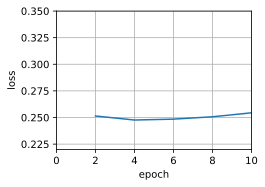

In [21]:
def train_sgd(lr, batch_size, num_epochs=2):
    data_iter, feature_dim = get_data_ch11(batch_size)
    return train_ch11(
        sgd, None, {'lr': lr}, data_iter, feature_dim, num_epochs)

gd_res = train_sgd(1, 1500, 10)

Khi kích thước của batch bằng 1, chúng ta sử dụng thuật toán SGD để tối ưu. Để đơn giản hóa việc hiện thực, chúng ta cố định tốc độ học (learning rate) bằng một hằng số (có giá trị nhỏ). Trong SGD, các tham số mô hình được cập nhật bất cứ khi nào có một mẫu huấn luyện được xử lý. Trong trường hợp này, sẽ có 1500 lần cập nhật trong mỗi epoch. Có thể thấy, sự suy giảm giá trị của hàm mục tiêu chậm lại sau một epoch. Mặc dù cả hai thuật toán cùng xử lý 1500 mẫu trong một epoch, SGD tốn thời gian hơn GD trong thí nghiệm trên. Điều này là do SGD cập nhật các tham số thường xuyên hơn và kém hiệu quả khi xử lý đơn lẻ từng mẫu.

loss: 0.248, 0.809 sec/epoch


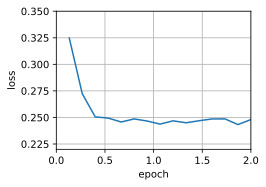

In [22]:
sgd_res = train_sgd(0.005, 1)

Cuối cùng, khi kích thước của batch bằng 100, chúng ta sử dụng thuật toán SGD theo minibatch để tối ưu. Thời gian cần thiết cho mỗi epoch ngắn hơn thời gian tương ứng của SGD và GD theo toàn bộ batch.

loss: 0.244, 0.020 sec/epoch


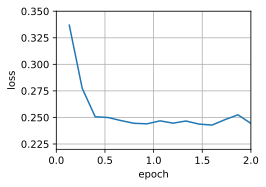

In [23]:
mini1_res = train_sgd(.4, 100)

Giảm kích thước của batch bằng 10, thời gian cho mỗi epoch tăng vì thực thi tính toán trên mỗi batch kém hiệu quả hơn.

loss: 0.246, 0.070 sec/epoch


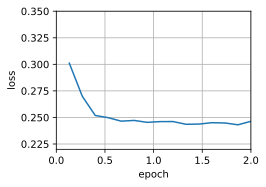

In [24]:
mini2_res = train_sgd(.05, 10)

Cuối cùng, chúng ta so sánh tương quan thời gian và giá trị hàm mấy mát trong bốn thí nghiệm trên. Có thể thấy, dù hội tụ nhanh hơn GD về số mẫu được xử lý, SGD tốn nhiều thời gian hơn để đạt được cùng giá trị mất mát như GD vì thuật toán này tính gradient descent trên từng mẫu một. Thuật toán SGD theo minibatch có thể cân bằng giữa tốc độ hội tụ và hiệu quả tính toán. Với kích thước minibatch bằng 10, thuật toán này hiệu quả hơn SGD; và với kích thước minibatch bằng 100, thời gian chạy của thuật toán này thậm chí nhanh hơn cả GD.

## Concise Implementation

Trong Gluon, chúng ta có thể sử dụng lớp `Trainer` để gọi các thuật toán tối ưu. Cách này được sử dụng để có thể hiện thực một hàm huấn luyện tổng quát. Chúng ta sẽ sử dụng hàm này xuyên suốt các phần tiếp theo của chương.

In [25]:
#@save
def train_concise_ch11(trainer_fn, hyperparams, data_iter, num_epochs=4):
    # Initialization
    net = nn.Sequential(nn.Linear(5, 1))
    def init_weights(module):
        if type(module) == nn.Linear:
            torch.nn.init.normal_(module.weight, std=0.01)
    net.apply(init_weights)

    optimizer = trainer_fn(net.parameters(), **hyperparams)
    loss = nn.MSELoss(reduction='none')
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            xlim=[0, num_epochs], ylim=[0.22, 0.35])
    n, timer = 0, d2l.Timer()
    for _ in range(num_epochs):
        for X, y in data_iter:
            optimizer.zero_grad()
            out = net(X)
            y = y.reshape(out.shape)
            l = loss(out, y)
            l.mean().backward()
            optimizer.step()
            n += X.shape[0]
            if n % 200 == 0:
                timer.stop()
                # `MSELoss` computes squared error without the 1/2 factor
                animator.add(n/X.shape[0]/len(data_iter),
                             (d2l.evaluate_loss(net, data_iter, loss) / 2,))
                timer.start()
    print(f'loss: {animator.Y[0][-1]:.3f}, {timer.sum()/num_epochs:.3f} sec/epoch')

loss: 0.243, 0.106 sec/epoch


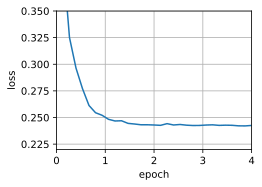

In [26]:
data_iter, _ = get_data_ch11(10)
trainer = torch.optim.SGD
train_concise_ch11(trainer, {'lr': 0.01}, data_iter)

## Excercises

### Exercise 1.

loss: 0.301, 0.115 sec/epoch


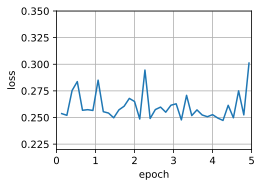

In [27]:
# Thử nghiệm với các giá trị khác nhau của tốc độ học và kích thước batch
# Tốc độ học lớn hơn và kích thước batch nhỏ hơn
experiment_1 = train_sgd(lr=0.1, batch_size=5, num_epochs=5)


loss: 0.282, 0.026 sec/epoch


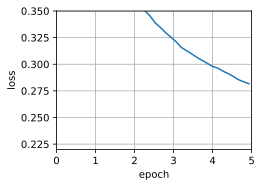

In [28]:
# Tốc độ học nhỏ hơn và kích thước batch lớn hơn
experiment_2 = train_sgd(lr=0.01, batch_size=50, num_epochs=5)


loss: 0.243, 0.039 sec/epoch


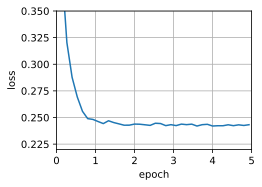

In [29]:
# Tốc độ học trung bình và kích thước batch trung bình
experiment_3 = train_sgd(lr=0.05, batch_size=20, num_epochs=5)

1. **Tốc độ học lớn hơn và kích thước batch nhỏ hơn**:
    - Với tốc độ học lớn và kích thước batch nhỏ, mô hình có thể hội tụ nhanh hơn nhưng dễ gặp phải dao động lớn trong quá trình tối ưu hóa do phương sai cao của gradient.

2. **Tốc độ học nhỏ hơn và kích thước batch lớn hơn**:
    - Với tốc độ học nhỏ và kích thước batch lớn, mô hình hội tụ ổn định hơn nhưng tốc độ hội tụ có thể chậm hơn do các bước cập nhật nhỏ.

3. **Tốc độ học trung bình và kích thước batch trung bình**:
    - Với tốc độ học và kích thước batch trung bình, mô hình đạt được sự cân bằng giữa tốc độ hội tụ và độ ổn định, thường mang lại kết quả tốt nhất.

Kích thước batch và tốc độ học là các siêu tham số quan trọng, cần được điều chỉnh phù hợp với bài toán cụ thể để đạt hiệu quả tối ưu.

### Exercise 2.

In [31]:
import mxnet as mx
from mxnet import gluon, nd

# Define a simple model
net = gluon.nn.Sequential()
net.add(gluon.nn.Dense(10))
net.initialize(mx.init.Xavier())

# Initialize Trainer with SGD optimizer
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.1})

# Simulate training loop
num_epochs = 5
for epoch in range(num_epochs):
    # Reduce learning rate by a factor of 10 after each epoch
    new_lr = trainer.learning_rate * 0.1
    trainer.set_learning_rate(new_lr)
    print(f'Epoch {epoch+1}: Learning rate = {new_lr}')


ModuleNotFoundError: No module named 'mxnet'